In [1]:
# 加载库
import os
import pandas as pd
import jieba  #中文分词工具，将中文文本分割成词语
from collections import Counter #统计元素出现次数
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS'] # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False # 用来正常显示负号

In [3]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer  #将文本转换为词频矩阵，文本特征提取工具
from sklearn.manifold import TSNE  #降维工具
from sklearn.cluster import KMeans  #聚类
from collections import OrderedDict
import re  #正则表达式库，用于处理和匹配字符串。
import tempfile
import pyLDAvis.gensim #主题模型分析

In [5]:
#Gensim 主题模型库
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import warnings
warnings.filterwarnings('ignore')#禁用警告消息的语句

In [12]:
# 步骤1：初始数据清洗
# coding=utf-8
# 数据去重
import pandas as pd

# 读取原始数据文件
df = pd.read_csv('C:/Users/liyutong/Desktop/语义分析/语义判断/weibo_sentiment.csv', encoding='gbk')
# 记录原始数据数量
original_count = len(df)
# 进行去重处理
df_unique = df.drop_duplicates()
# 计算删除的数据数量
deleted_count = original_count - len(df_unique)
print("原始数据量:", original_count)
print("去重-删除的数据数量：", deleted_count)

原始数据量: 120004
去重-删除的数据数量： 16


In [15]:
import pandas as pd
from sklearn.ensemble import IsolationForest

# 读取数据文件
data = df_unique

# 选择数值型的列
numeric_columns = data.select_dtypes(include=[float, int]).columns
data_numeric = data[numeric_columns]

# 构建孤立森林模型
model = IsolationForest(n_estimators=100, contamination=0.1)

# 拟合模型
model.fit(data_numeric)

# 进行离群值检测
outliers = model.predict(data_numeric)

# 将离群值标记为-1，正常值标记为1
outliers[outliers == 1] = 0
outliers[outliers == -1] = 1

# 计算异常值比例
outlier_ratio = sum(outliers) / len(outliers)
retained_ratio = 1 - outlier_ratio

# 输出删除的数据行、保留的数据行和异常值比例
print("删除的数据行：", sum(outliers))
print("保留的数据行：", len(outliers) - sum(outliers))
print("异常值比例：", outlier_ratio)

删除的数据行： 0
保留的数据行： 119988
异常值比例： 0.0


In [17]:
# 为了本次实验的效率，保留其中4000条数据即可，负面评论2000条，正面评论2000条
# 提取标签为 1 的前 2000 条数据
data_label_1 = data[data['label'] == 1].head(2000)
# 提取标签为 0 的前 2000 条数据
data_label_0 = data[data['label'] == 0].head(2000)
import pandas as pd
# 合并提取出来的数据
merged_data = pd.concat([data_label_1, data_label_0])
# 保存合并后的数据到 CSV 文件
merged_data.to_csv('weibo_sentiment_new.csv', index=False, encoding='gbk')

print("保存成功！")

保存成功！


In [19]:
def count_word_freq_from_df(df, text_col, stopwords_file, save_path):
 
    """
    统计指定列的文本数据中的词频
    :param df: 包含文本数据的pandas DataFrame
    :param text_col: 指定列的列名
    :param stopwords_file: 停用词文件路径
    :param save_path: 保存结果的Excel文件路径
    :return: None
    """
    # 读取停用词表
    stopwords = set()
    with open(stopwords_file, 'r', encoding='utf-8') as f:
        for line in f:
            stopwords.add(line.strip())

    # 统计词频
    word_freq = Counter()
    for content in df[text_col]:
        try:
            words = jieba.cut(content)
            for word in words:
                if len(word) > 1 and word not in stopwords:
                    word_freq[word] += 1
        except:
            continue

    # 将结果保存到csv中
    df = pd.DataFrame({'word': list(word_freq.keys()), 'freq': list(word_freq.values())})
    df = df[df['word'].str.match('^[\u4e00-\u9fa5]+$')]  # 删除非汉字的词频
    df.sort_values(by='freq', ascending=False, inplace=True)
    df.to_csv(save_path, index=False,encoding='gbk')

In [28]:
df=pd.read_csv('weibo_sentiment_new.csv',encoding='gbk')
count_word_freq_from_df(df, 'review', 'C:/Users/liyutong/Desktop/语义分析/语义判断/baidu_stopwords.txt', '词频.csv')
print('词频.csv-保存成功!')
count_word_freq_from_df(data_label_1,'review', 'C:/Users/liyutong/Desktop/语义分析/语义判断/baidu_stopwords.txt', '词频1.csv')
print('词频1.csv-保存成功!')
count_word_freq_from_df(data_label_0,'review', 'C:/Users/liyutong/Desktop/语义分析/语义判断/baidu_stopwords.txt', '词频0.csv')
print('词频0.csv-保存成功!')

词频.csv-保存成功!
词频1.csv-保存成功!
词频0.csv-保存成功!


In [ ]:
## 步骤2.2：定义一个函数，传入一个词频数据文件作为参数，数据格式为列表，
#每个元素是一个元组，元组的第一个元素是词语，第二个元素是该词语的频率。
#然后，函数根据词频数据生成词云图，并将结果保存为 wordcloud.png 文件，并在绘图结束后显示词云图。

In [30]:
def draw_wordcloud(data):
    """
    根据词频数据绘制词云图
    :param data: 词频数据，格式为[(word1, freq1), (word2, freq2), ...]
    :return: None
    """
    wordcloud = WordCloud(font_path='SimHei.ttf', background_color='white',max_words=300, width=1000, height=800)
    wordcloud.fit_words(dict(data))
    plt.figure(figsize=(16, 12),dpi=300)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.savefig('wordcloud.png', dpi=300)
    plt.show()

In [ ]:
## # 步骤2.3：调用count_word_freq_from_df方法，对步骤步骤1当中处理后的数据，统计指定列的文本数据中每个词的出现频率，
## 同时过滤掉长度为 1 的词和停用词。并将词频数据结果保存到：词频.csv文件当中
# 调用：draw_wordcloud方法：读取词频.csv文件，根据词频数据生成词云图，并将结果保存为 wordcloud.png 文件，并在绘图结束后显示词云图。

In [ ]:
# 模块3:步骤3.1：定义一个函数,进行中文文本的预处理：去除一些无用的字符只提取出中文出来，分词操作：把文本分割成词语，将所有可能的词语全部列出来。
# 并且加载了一个停用词库，通过读取 baidu_stopwords.txt 文件，并将停用词存储在一个集合中。然后在分词结果中去除停用词，只保留不在停用词库中且长度大于1的词语。并将处理后的结果存储到 DataFrame对象当中
# 调用分词函数,对步骤1处理后的df进行处理,提取出符合规范的词语.并且把所有的分词结果保存到corpus列表当中

In [34]:
def chinese_word_cut(mytext):
    # 文本预处理 ：去除一些无用的字符只提取出中文出来
    new_data = re.findall('[\u4e00-\u9fa5]+', mytext, re.S)
    new_data = " ".join(new_data)
    # 文本分词
    seg_list_exact = jieba.cut(new_data, cut_all=True)
    result_list = []
    # 加载停用词库
    with open('C:/Users/liyutong/Desktop/语义分析/语义判断/baidu_stopwords.txt', encoding='utf-8') as f: # 可根据需要打开停用词库，然后加上不想显示的词语
        stop_words = set()
        for i in f.readlines():
            stop_words.add(i.replace("\n", "")) # 去掉读取每一行数据的\n
    # 去除停用词
    for word in seg_list_exact:
        if word not in stop_words and len(word) > 1:
            result_list.append(word)
    return " ".join(result_list)

df['分词结果'] = df['review'].apply(chinese_word_cut)

df.head()

,label,review,分词结果
0,1,?更博了，爆照了，帅的呀，就是越来越爱你！生快傻缺[爱你][爱你][爱你],越来 越来越
1,1,@张晓鹏jonathan 土耳其的事要认真对待[哈哈]，否则直接开除。@丁丁看世界 很是细心...,土耳其 认真对待 真对 对待 开除 丁丁 世界 细心 酒店
2,1,姑娘都羡慕你呢…还有招财猫高兴……//@爱在蔓延-JC:[哈哈]小学徒一枚，等着明天见您呢/...,姑娘 羡慕 招财 招财猫 蔓延 小学 学徒 一枚 明天 大佬 书呆 书呆子 呆子
3,1,美~~~~~[爱你],
4,1,梦想有多大，舞台就有多大![鼓掌],梦想 想有 舞台 鼓掌


In [36]:
df=df[['label','review','分词结果']]
df.to_csv('weibo_sentiment_fc.csv',encoding='gbk',index=False)

In [38]:
corpus=[]
a=[]
for i in range(len(df['分词结果'])):
    try:
        a=df['分词结果'][i]
        corpus.append(a)
    except:
        # print(i)
        continue
corpus[0:10]

['越来 越来越',
 '土耳其 认真对待 真对 对待 开除 丁丁 世界 细心 酒店',
 '姑娘 羡慕 招财 招财猫 蔓延 小学 学徒 一枚 明天 大佬 书呆 书呆子 呆子',
 '',
 '梦想 想有 舞台 鼓掌',
 '花心 鼓掌 懒猫 春暖花开 花开',
 '问答 社区 上收 收到 一大 大学 大学生 学生 生发 发给 私信 喜欢 阿姨 阿姨 阿姨 稀饭',
 '吃货 无不 啧啧 啧啧称奇 称奇 喜欢 写错 一个 森林 小天使 天使 厦门 摄影 摄影师 日月 日月星 日月星辰 星辰 路上 每种 型号 两胎 志远 远天 天下 下行 监控 防盗 安装 创意 美食 漫游 漫游者 游者 强子 游子 厦门',
 '享受 生活 微笑 呵呵 嘻嘻 挤眼 开心 早安 甜心',
 '霍思燕 剖腹 剖腹产 产下 老公 落泪 今晨 霍思燕 产下 一名 男婴 宝宝 母子 平安 脸上 洋溢 洋溢着 爸爸 欣喜 宝宝 小名 名叫 眼睛 鼻子 嘴巴 霍思燕 宝贝 忍不住 不住 落泪 恭喜 侦察 霍思燕 祝福 健康 成长']

In [40]:
len(corpus)

4000

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib
# 创建一个 TfidfVectorizer 对象
tfidf_vectorizer = TfidfVectorizer()
# 对分词结果进行 TF-IDF 加权处理
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)  # corpus 是你的文本数据
# 输出 TF-IDF 加权后的结果
print(tfidf_matrix)
# 将 tfidf_vectorizer 对象保存为文件
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')

  (0, 15700)	0.7071067811865475
  (0, 15699)	0.7071067811865475
  (1, 16373)	0.21311858025761277
  (1, 13680)	0.3582541142349978
  (1, 858)	0.23110660510681313
  (1, 292)	0.3359246409130943
  (1, 7348)	0.37597801431603894
  (1, 6455)	0.32795490691967294
  (1, 12829)	0.37597801431603894
  (1, 15222)	0.37597801431603894
  (1, 4926)	0.3582541142349978
  (2, 4404)	0.28651410483805606
  (2, 1288)	0.2948335486199699
  (2, 1287)	0.2948335486199699
  (2, 5305)	0.30555917709872876
  (2, 9632)	0.1926470217856936
  (2, 160)	0.26459970002728866
  (2, 6124)	0.2948335486199699
  (2, 6561)	0.2606715520629566
  (2, 14795)	0.32067610139506936
  (2, 8591)	0.30555917709872876
  (2, 8590)	0.28651410483805606
  (2, 13932)	0.24812688366336055
  (2, 5992)	0.2209760239231544
  (4, 17729)	0.2569565450635395
  :	:
  (3997, 8267)	0.19699538242153616
  (3997, 4165)	0.24111123952274138
  (3997, 12)	0.11627666221729203
  (3998, 11181)	0.4910459112489163
  (3998, 157)	0.41319916429691905
  (3998, 8026)	0.39461618236

['tfidf_vectorizer.pkl']

In [44]:
plt.rcParams['xtick.bottom'] = True  # 设置横轴刻度线可见
plt.rcParams['ytick.left'] = True  # 设置纵轴刻度线可见
plt.rcParams['figure.autolayout'] = True  #自动tight布局，解决多个plots出现重叠问题
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 解决中文显示问题
plt.rcParams['figure.dpi'] = 100  # 设备图形分辨率

              precision    recall  f1-score   support

           0       0.71      0.85      0.78       378
           1       0.84      0.69      0.76       422

    accuracy                           0.77       800
   macro avg       0.78      0.77      0.77       800
weighted avg       0.78      0.77      0.77       800



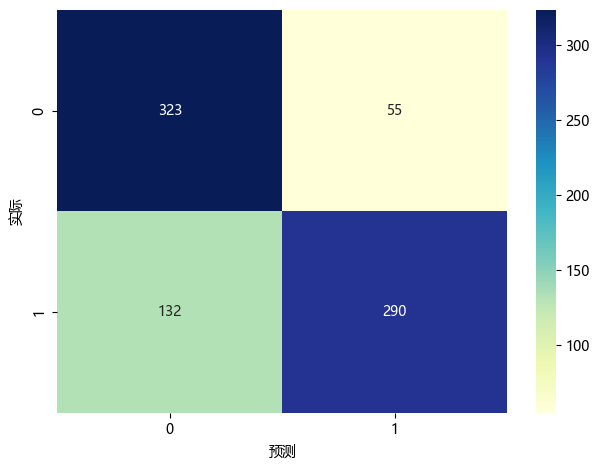

['svm_model.pkl']

In [46]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

#  tfidf_matrix 是经过 TF-IDF 加权后的稀疏矩阵，labels 是对应的标签
#  labels 包含了 0 和 1 两种类别（负面和正面情感）
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, df['label'], test_size=0.2, random_state=42)
# 创建 SVM 分类器
svm_classifier = SVC(kernel='linear')
# 训练 SVM 模型
svm_classifier.fit(X_train, y_train)
# 在测试集上进行预测
y_pred = svm_classifier.predict(X_test)
# 输出分类报告
print(classification_report(y_test, y_pred))
# 输出混淆矩阵
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="YlGnBu")
plt.xlabel('预测')
plt.ylabel('实际')
plt.show()
# 保存训练好的模型
joblib.dump(svm_classifier, 'svm_model.pkl')


In [48]:
from sklearn.metrics import accuracy_score
# 单独输出准确率
accuracy = accuracy_score(y_test, y_pred)
print("准确率：{:.2f}%".format(accuracy*100))

准确率：76.62%


              precision    recall  f1-score   support

           0       0.68      0.80      0.73       378
           1       0.79      0.66      0.72       422

    accuracy                           0.72       800
   macro avg       0.73      0.73      0.72       800
weighted avg       0.73      0.72      0.72       800



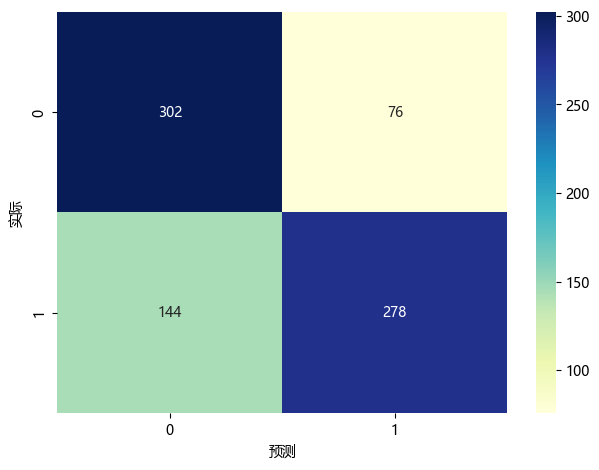

决策树模型准确率：72.50%


In [50]:
from sklearn.tree import DecisionTreeClassifier

# 创建决策树分类器
dt_classifier = DecisionTreeClassifier()
# 训练决策树模型
dt_classifier.fit(X_train, y_train)
# 在测试集上进行预测
y_pred_dt = dt_classifier.predict(X_test)
# 输出分类报告
print(classification_report(y_test, y_pred_dt))
# 输出混淆矩阵
conf_mat_dt = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(conf_mat_dt, annot=True, fmt='d', cmap="YlGnBu")
plt.xlabel('预测')
plt.ylabel('实际')
plt.show()
# 保存训练好的决策树模型
joblib.dump(dt_classifier, 'decision_tree_model.pkl')
# 单独输出决策树模型的准确率
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print("决策树模型准确率：{:.2f}%".format(accuracy_dt*100))
